In [1]:
## general imports
import csv
import numpy as np
from numpy import *
fact = np.math.factorial

import scipy as sp
from scipy.integrate import quad, dblquad
from scipy.special import eval_hermite as Hermite
from scipy.special import eval_genlaguerre as Laguerre

from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
#sys.path.append(os.path.join("..","."))
#from field_funcs import * # my helper functions
#from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('.','images')
print("images saved in", imagedir)

# define some length units
mm = 10**-3
um = 10**-6
nm = 10**-9

#Define some variables for the cavity
L = 3.95*mm #Length between mirrors along cavity axis
R1 =2*mm  #Radius of Mirror 1
R2 = 2*mm #Radius of Mirror 2
R = 2*mm


lmbda = 7.8*10**-4*mm
z = 10**-10
w0 = sqrt(lmbda*L/(2*pi))*((R-L/2)/(L/2))**(1/4)
zR = pi*w0**2/lmbda

#Some bounds needed for TEM component overlap integrals
xmax = ymax = 20*w0
xmin = ymin = -xmax

C:\Users\louis\AppData\Local\Temp\ipykernel_15568\1149860380.py:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  fact = np.math.factorial
C:\Users\louis\AppData\Local\Temp\ipykernel_15568\1149860380.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display, Image


images saved in .\images


In [2]:
def dblquad_complex(func, ax, bx, ay, by, **kwargs):
    """
    Compute a double integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    
    returns a 3-tuple (result, real error, imaginary part error)
    """
    def real_func(x,y):
        return real(func(x,y))
    def imag_func(x,y):
        return imag(func(x,y))
    real_integral = dblquad(real_func, ax, bx, hfun=by, gfun=ay, **kwargs)
    imag_integral = dblquad(imag_func, ax, bx, hfun=by, gfun=ay, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

def HGmn(w0,lmbda,m,n):
    """
    return a lambda function Amn(x,y,z) for the amplitude of the 
    (m,n)th Hermite-Gaussian beam with fundamental waist w0
    at location z.
    """
    
    k = 2*pi/lmbda # wavenumber
    zR = pi*w0**2/lmbda # Rayleigh range
    w = lambda z: w0*sqrt(1+(z/zR)**2) # width
    R = lambda z: z*(1+(zR/z)**2) # radius of curvature
    eta = lambda z: arctan(z/zR) # Guoy phase
    
    Amn = lambda x,y,z: (sqrt(2/(pi*2**(m+n)*fact(m)*fact(n)))*(1/w(z))
                        *(Hermite(m,sqrt(2)*x/w(z))*Hermite(n,sqrt(2)*y/w(z)))
                        *exp(-(x**2+y**2)/w(z)**2)
                        *exp(1j*k*(x**2+y**2)/(2*R(z)))
                        *exp(-1j*(m+n+1)*eta(z))       )
    return Amn

def get_meshgrid(w, pts, polar=False):
    """
    Args:
        'w': grid half width
        'pts': pts along one dimension; i.e. the full grid is pts x pts
        'polar': will return rr and phi meshgrid instead of xx,yy
    Returns:
        xarr, midpt, and xx,yy or rr,phi
    """
    midpt = int(pts/2)
    x = linspace(-w, w, pts)
    y = linspace(-w, w, pts)
    xx, yy = meshgrid(x,y, sparse=True)
    if polar:
        rr = sqrt(xx**2 + yy**2)
        phi = arctan2(yy,xx)
        phi[:midpt, :] += 2*pi
        return x,midpt,rr,phi
    else:
        return x,midpt,xx,yy

In [3]:
"""
The functions in this cell calculate the variables necessary in computing the TEM mode components for 4 misalignments: alpha,dx,beta,dy
    Parameters:
        alpha: int/float. Rotational misalignment of mirror about the y axis in the clockwise direction
        dx: int/float. Translational misalignment of mirror along the x axis in the POSITIVE direction
        beta: int/float. Rotatinoal misalignment of mirror about the x axis in the clockwise direction
        dy: int/float. Translational misalignment of mirror along the y axis in the NEGATIVE direction
    Calculated variables:
        theta: cavity mode tilt in the xz plane
        phi: cavity mode tilt in the yz plane
        (x,y,z)dec: decentering of the cavity axis center
"""

def calculate_theta(alpha,dx,beta,dy):
    theta = arctan((dx + R*sin(alpha)) / -(R + R*cos(alpha)*cos(beta) - L))
    return theta

def calculate_phi(alpha,dx,beta,dy):
    phi = float(arctan((dy + R*cos(alpha)*sin(beta)) / (R + R*cos(alpha)*cos(beta) - L)))
    return phi

def calculate_xdec(alpha,dx,beta,dy):
    B = dx + R*sin(alpha)
    xdec = (1/2)*B
    return xdec

def calculate_ydec(alpha,dx,beta,dy):
    E = -(R*cos(alpha)*sin(beta) + dy)
    ydec = (1/2)*E
    return ydec

def calculate_zdec(alpha,dx,beta,dy):
    zdec = (R/2)*(1 - cos(alpha)*cos(beta))
    return zdec

In [4]:
"""
The functions in this cell are needed to calculate the 'clipping' of each mode due to 4 misalignments

NOTE: Clipping is calculated for each (m,n) mode as the ratio of suriving power after misalignment to the total power.
    For calculating total power (the method calculate Ptotal(...)), I was unsure whether or not I should set it equal to:
        1. (pi/2)*(waist_at_mirror(4 misalignments))^2
        2. the surviving power integral with all misalignments set to 0, i.e. P_surv(0,0,0,0,m,n)
    ---> With option 2, the total power changes for each (m,n) mode. With option 1, it stays the same for all of them.
"""

def calculate_L(alpha,dx,beta,dy):
    #calculates new length between mirrors
    c = sqrt( (dx+R*sin(alpha))**2 + (R*cos(alpha)*sin(beta) + dy)**2 + (R - L + R*cos(alpha)*cos(beta))**2 )
    L_prime = 2*R - c
    return L_prime

def calculate_waist(alpha,dx,beta,dy):
    #Calculates New Waist for given L_prime
    if(alpha == 0 and dx == 0 and beta == 0 and dy == 0):
        return w0
    else:
        L_prime=calculate_L(alpha,dx,beta,dy)
        waist = sqrt(lmbda*L_prime/(2*pi))*((R-(L_prime/2))/(L_prime/2))**(1/4)
        #waist = sqrt((lmbda*L_prime)/(2*pi))*(((R-(L_prime/2))/(L_prime/2))**(1/4))
        return waist
def calculate_waist_mirror(alpha,dx,beta,dy):
    #Calculates new waist at the mirror
    waist_center = calculate_waist(alpha,dx,beta,dy)
    L_prime=calculate_L(alpha,dx,beta,dy)
    w_mirror = waist_center*sqrt(1+((L_prime/2)/(pi*waist_center**2/lmbda))**2)
    return w_mirror

def calculate_L_xz(alpha,dx,beta,dy):
    #Calculates the new cavity length as projected in the xz plane
    L_prime = calculate_L(alpha,dx,beta,dy)
    theta = calculate_theta(alpha,dx,beta,dy)
    phi = calculate_phi(alpha,dx,beta,dy)
    proj = sqrt(sin(theta)**2 + (cos(phi)*cos(theta))**2)
    L_xz = L_prime*proj
    return L_xz

def calculate_L_yz(alpha,dx,beta,dy):
    #Calculates the new cavity length as projected in the yz plane
    L_prime = calculate_L(alpha,dx,beta,dy)
    theta = calculate_theta(alpha,dx,beta,dy)
    phi = calculate_phi(alpha,dx,beta,dy)
    proj = sqrt((sin(phi)*cos(theta))**2 + (cos(phi)*cos(theta))**2)
    L_yz = L_prime*proj
    return L_yz

def calculate_Psurv(alpha,dx,beta,dy,m,n):
    #Finds the surviving power of 
    r=mm/2
    L_prime = calculate_L(alpha,dx,beta,dy)
    L_xz = calculate_L_xz(alpha,dx,beta,dy)
    L_yz = calculate_L_yz(alpha,dx,beta,dy)
    waist_center = calculate_waist(alpha,dx,beta,dy)
    waist_mirror = calculate_waist_mirror(alpha,dx,beta,dy)
    theta = calculate_theta(alpha,dx,beta,dy)
    phi = calculate_phi(alpha,dx,beta,dy)
    xdec = calculate_xdec(alpha,dx,beta,dy)
    ydec = calculate_ydec(alpha,dx,beta,dy)
    delta = abs(theta) - abs(alpha)
    gamma = abs(phi) - abs(beta)
    #print("L_prime = " + str(L_prime))
    #print("Waist_center = " + str(waist_center))
    #print("Theta = " + str(theta))
    #print("xdec = " + str(xdec))
    #print("delta = " + str(delta))
    x0 = -(L_xz/2)*sin(theta) - xdec + dx
    y0 = -((L_yz/2)*sin(phi) + ydec + dy)
    #print("y0 = " + str(y0))
    #print("x0 = " + str(x0))
    #print("x0 = " + str(x0))
    func = lambda x,y: exp((-2/(waist_mirror*cos(delta)*sqrt(2*m+1))**2)*((x-x0)**2))*exp((-2/(waist_mirror*cos(gamma)*sqrt(2*n+1))**2)*((y-y0)**2))
    P_surv = dblquad(func, -r,r,lambda x: -sqrt(r**2 - x**2),lambda x: sqrt(r**2 - x**2))
    return P_surv

def calculate_Ptotal(alpha,dx,beta,dy,m,n):
    #waist_mirror = calculate_waist_mirror(alpha,dx,beta,dy)
    #P_total = (pi/2)*(waist_mirror)**2
    P_total = calculate_Psurv(0,0,0,0,m,n)
    return P_total

def calculate_clipping(alpha,dx,beta,dy,m,n):
    if(alpha == 0 and dx == 0 and beta == 0 and dy == 0):
        return float(1)
    else:
        P_surv = calculate_Psurv(alpha,dx,beta,dy,m,n)[0]
        #print(P_surv)
        P_total = calculate_Ptotal(alpha,dx,beta,dy,m,n)[0]
        return sqrt(P_surv/P_total)

In [5]:
"""
This cell contains the functions which compute the numerical value of the TEM mode components c_mn, up to m=n=2
Parameters: alpha,dx,beta,dy are now input as a list: vec[0,1,2,3] = alpha,dx,beta,dy respectively
Units:
    alpha, beta: mrads. For accurate outputs, -15<alpha,beta<15
    dx, dy: microns. For accurate outputs, -15<dx,dy<15
"""

def calculate_overlap00(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,0,0)
    #print("00 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A00prime = HGmn(w0prime,lmbda,0,0)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A00prime( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_00 = " + str(overlap))
    return overlap

def calculate_overlap10(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,1,0)
    #print("10 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A10 = HGmn(w0prime,lmbda,1,0)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A10( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_10 = " + str(overlap))
    return overlap

def calculate_overlap01(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,0,1)
    #print("01 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A01 = HGmn(w0prime,lmbda,0,1)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A01( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_01 = " + str(overlap))
    return overlap

def calculate_overlap11(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,1,1)
    #print("11 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A11 = HGmn(w0prime,lmbda,1,1)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A11( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_11 = " + str(overlap))
    return overlap

def calculate_overlap20(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,2,0)
    #print("20 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A20 = HGmn(w0prime,lmbda,2,0)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A20( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_20 = " + str(overlap))
    return overlap

def calculate_overlap02(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,0,2)
    #print("02 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A02 = HGmn(w0prime,lmbda,0,2)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A02( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_02 = " + str(overlap))
    return overlap

def calculate_overlap21(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,2,1)
    #print("21 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A21 = HGmn(w0prime,lmbda,2,1)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A21( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_21 = " + str(overlap))
    return overlap

def calculate_overlap12(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,1,2)
    #print("12 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A12 = HGmn(w0prime,lmbda,1,2)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A12( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_12 = " + str(overlap))
    return overlap

def calculate_overlap22(vec): #vec = [alpha,dx,beta,dy], as a list
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    w0prime = calculate_waist(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    clipping = calculate_clipping(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um,2,2)
    #print("22 clipping = " + str(clipping))
    A00 = HGmn(w0,lmbda,0,0)
    A22 = HGmn(w0prime,lmbda,2,2)
    integrand = lambda x,y:conjugate(A00(x,y,z))*A22( (x-xdec)*cos(theta) + (z-zdec)*sin(theta), -(x-xdec)*sin(phi)*sin(theta) + (y-ydec)*cos(phi) + (z-zdec)*sin(phi)*cos(theta) , -(x-xdec)*cos(phi)*sin(theta) - (y-ydec)*sin(phi) + (z-zdec)*cos(phi)*cos(theta) ) * clipping
    overlap = dblquad_complex(integrand, ax=xmin, bx=xmax, ay=ymin, by=ymax)[0]
    #print("With alpha = " + str(vec[0]) + " milliradians, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " milliradians, dy = " + str(vec[3]) + " microns, theta = " + str(theta) + ", phi = " + str(phi) + ", xdec of " + str(xdec) + " , ydec of " + str(ydec) +  ", and zdec = " + str(zdec) + ", a (clipped) overlap c_22 = " + str(overlap))
    return overlap

In [6]:
"""
The function in this cell displays a cross section of the misaligned cavity beam output at the center of the optical axis
Parameters:
    - vec: A list of floats, [alpha,dx,beta,dy]. For accurate plots, each float should be between -15 and 15.
        -Units: Alpha and beta are scaled to mrads, dx and dy are scaled to microns
    - Returns: 2D plot of expected modal content due to misalignment from the four parameters.
"""

def plotsim(vec):
    theta = calculate_theta(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    phi = calculate_phi(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    xdec = calculate_xdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    ydec = calculate_ydec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    zdec = calculate_zdec(vec[0]*mm,vec[1]*um,vec[2]*mm,vec[3]*um)
    
    
    hw = 3*w0
    pts = 1000
    xarr, midpt, xx, yy = get_meshgrid(hw,pts)
    fig,axes = plt.subplots(figsize=(6,6))
    c00 = calculate_overlap00(vec)
    c10 = calculate_overlap10(vec)
    c01 = calculate_overlap01(vec)
    c11 = calculate_overlap11(vec)
    c20 = calculate_overlap20(vec)
    c21 = calculate_overlap21(vec)
    c02 = calculate_overlap02(vec)
    c12 = calculate_overlap12(vec)
    c22 = calculate_overlap22(vec)
    A00 = HGmn(w0,lmbda,0,0)
    A10 = HGmn(w0,lmbda,1,0)
    A01 = HGmn(w0,lmbda,0,1)
    A11 = HGmn(w0,lmbda,1,1)
    A20 = HGmn(w0,lmbda,2,0)
    A21 = HGmn(w0,lmbda,2,1)
    A02 = HGmn(w0,lmbda,0,2)
    A12 = HGmn(w0,lmbda,1,2)
    A22 = HGmn(w0,lmbda,2,2)
    a00 = lambda x,y: A00(x,y,um*mm)
    a10 = lambda x,y: A10(x,y,um*mm)
    a01 = lambda x,y: A01(x,y,um*mm)
    a11 = lambda x,y: A11(x,y,um*mm)
    a20 = lambda x,y: A20(x,y,um*mm)
    a21 = lambda x,y: A21(x,y,um*mm)
    a02 = lambda x,y: A02(x,y,um*mm)
    a12 = lambda x,y: A12(x,y,um*mm)
    a22 = lambda x,y: A22(x,y,um*mm)
    print("alpha = " + str(vec[0]) + " mrad, dx = " + str(vec[1]) + " microns, beta = " + str(vec[2]) + " mrad, dy = " + str(vec[3]) + " microns")
    print("theta = " + str(theta) + "rad , phi = " + str(phi) + "rad, (xdec,ydec,zdec) = (" + str(xdec) + "," + str(ydec) + "," + str(zdec) + ")")
    axes.imshow(abs(c00*a00(xx,yy))**2 + abs(c10*a10(xx,yy) + c01*a01(xx,yy))**2 + abs(c11*a11(xx,yy) + c20*a20(xx,yy) + c02*a02(xx,yy))**2 + abs(c21*a21(xx,yy) + c12*a12(xx,yy))**2 + abs(c22*a22(xx,yy))**2)
    #axes.text(30,50,'Before alignment',color='white')

alpha = 0 mrad, dx = 0 microns, beta = 2 mrad, dy = 4 microns
theta = -0.0rad , phi = 0.15866769164903394rad, (xdec,ydec,zdec) = (0.0,-3.999998666666933e-06,1.999999333368585e-09)


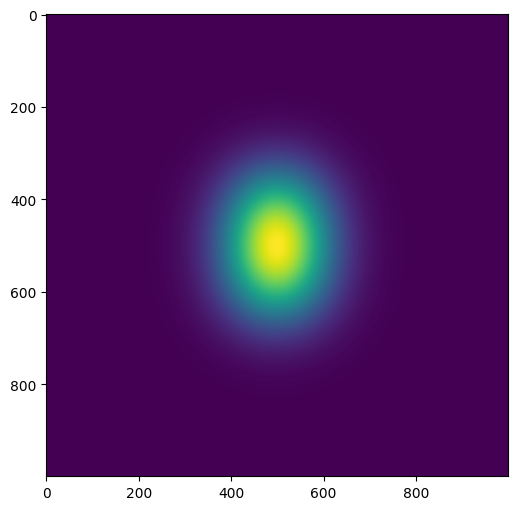

In [7]:
plotsim([0,0,2,4])

alpha = 2 mrad, dx = 4 microns, beta = 0 mrad, dy = 0 microns
theta = -0.15866769164903394rad , phi = 0.0rad, (xdec,ydec,zdec) = (3.999998666666933e-06,-0.0,1.999999333368585e-09)


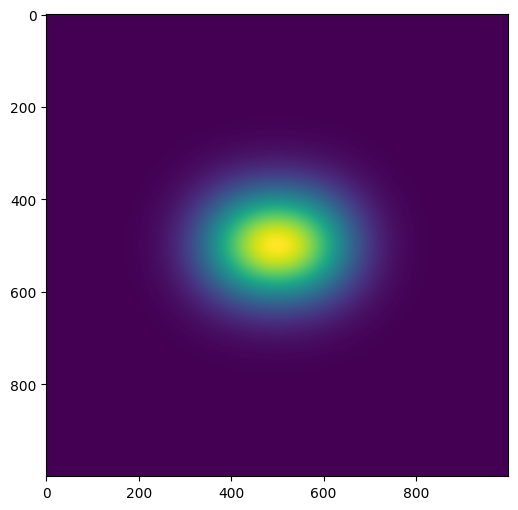

In [8]:
plotsim([2,4,0,0])

alpha = 2 mrad, dx = 4 microns, beta = 2 mrad, dy = 4 microns
theta = -0.1586801750362509rad , phi = 0.15868001900644177rad, (xdec,ydec,zdec) = (3.999998666666933e-06,-3.999994666670933e-06,3.9999946667146345e-09)


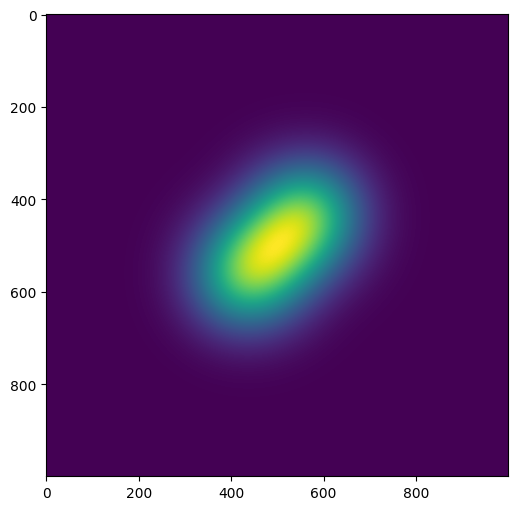

In [9]:
plotsim([2,4,2,4])

alpha = -4 mrad, dx = -8 microns, beta = -3 mrad, dy = 14 microns
theta = 0.30984776050716295rad , phi = 0.15873441511018258rad, (xdec,ydec,zdec) = (-7.999989333341866e-06,-4.000028499929974e-06,1.249994995844439e-08)


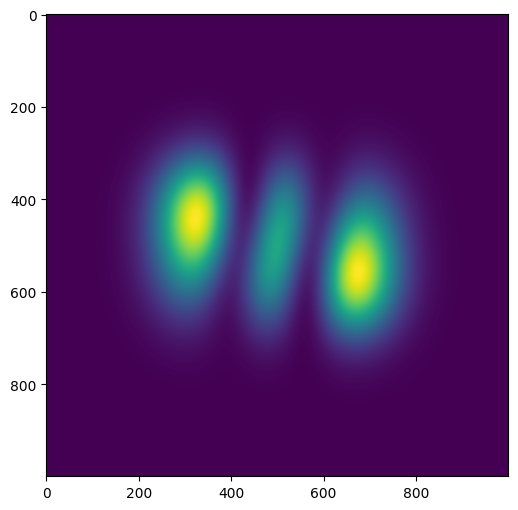

In [10]:
plotsim([-4,-8,-3,14])